In [2]:
import torch
from torch import nn
from torch import optim
from torchvision import models, transforms, datasets

import json 
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

import numpy as np
import os
import matplotlib.pyplot as plt

from PIL import ImageOps
from PIL import Image

In [3]:
state_dict = torch.load("checkpoint_9.pth",map_location=torch.device('cpu'))

In [4]:
model = models.mobilenet_v3_large(pretrained=False)

model.classifier = nn.Sequential(nn.Linear(960,1280),
                                nn.ReLU(),
                                nn.Linear(1280,10),
                                nn.LogSoftmax(dim=1))

model.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

In [14]:
dir_path = 'data/'
poses = os.listdir(dir_path)
image_path = dir_path + poses[8]+ "/" + os.listdir(dir_path + poses[8] + '/')[0]
image_path

'data/tree_pose/00000001.jpg'

In [6]:
class Resize(object):
    def __init__(self, size=224):
        self.size = size
        
    def __call__(self, im):  
        if(im.height > im.width):
            
            w = int(self.size*im.width/im.height)
            h = self.size
            pad_val = int((224-w)/2)
            pad = (224-w-pad_val,0,pad_val,0)
        else:
            h = int(self.size*im.height/im.width)
            w = self.size
            pad_val = int((224-h)/2)
            pad = (0,224-h-pad_val,0,pad_val)
        return ImageOps.expand(im.resize((w,h),resample=Image.BILINEAR), pad)

test_transform = transforms.Compose([Resize(),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     ])

In [7]:
def view_classify(img, ps, id_dict):
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(12,15), ncols=2)
    ax1.imshow(img.permute(1, 2, 0).numpy())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(list(id_dict.values()), size='small')
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    
    plt.tight_layout()
    plt.show()

In [8]:
pose_list = ['cobra_pose',
             'down_dog',
             'Legs-Up-the-Wall_Pose_or_Viparita_Karani',
             'Low_Lunge_pose_or_Anjaneyasana',
             'Plank_Pose_or_Kumbhakasana',
             'Standing_Forward_Bend_pose_or_Uttanasana',
             'Supported_Shoulderstand_pose_or_Salamba_Sarvangasana',
             'tree_pose',
             'warrior_pose',
             'goddess']

In [9]:
id_to_pose = {}
for i, pose in enumerate(pose_list):
    id_to_pose[i] = pose
id_to_pose

{0: 'cobra_pose',
 1: 'down_dog',
 2: 'Legs-Up-the-Wall_Pose_or_Viparita_Karani',
 3: 'Low_Lunge_pose_or_Anjaneyasana',
 4: 'Plank_Pose_or_Kumbhakasana',
 5: 'Standing_Forward_Bend_pose_or_Uttanasana',
 6: 'Supported_Shoulderstand_pose_or_Salamba_Sarvangasana',
 7: 'tree_pose',
 8: 'warrior_pose',
 9: 'goddess'}

In [10]:
def get_pose(model,image_path,id_dict,transform):
    
    model.eval()
    image = transform(Image.open(image_path))
    h, w, c = image.shape
    print(image.shape)
    image_test = image.view(1,h,w,c)
    
    with torch.no_grad():
        
        out = model(image_test)
        probs = torch.exp(out)
        top_p, top_class = probs.topk(1,dim=1)
        
    view_classify(image,probs,id_dict)
    pred = top_class.numpy()
    
    return id_dict[pred[0][0]]

torch.Size([3, 224, 224])


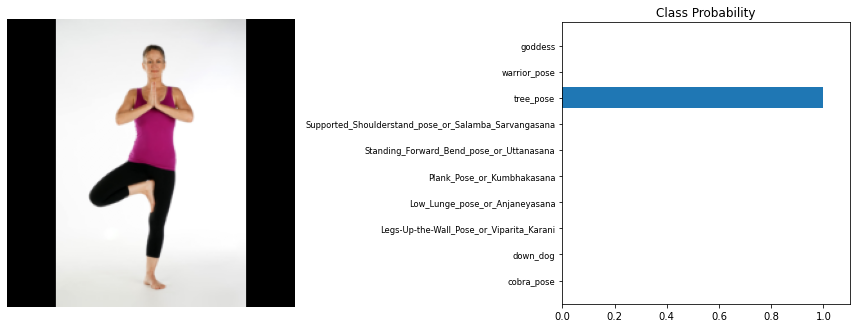

'tree_pose'

In [15]:
get_pose(model,image_path,id_to_pose,test_transform)

In [20]:
with open("id_to_pose.json","w") as file:
    json.dump(id_to_pose,file)

In [18]:
id_to_pose

{0: 'cobra_pose',
 1: 'down_dog',
 2: 'Legs-Up-the-Wall_Pose_or_Viparita_Karani',
 3: 'Low_Lunge_pose_or_Anjaneyasana',
 4: 'Plank_Pose_or_Kumbhakasana',
 5: 'Standing_Forward_Bend_pose_or_Uttanasana',
 6: 'Supported_Shoulderstand_pose_or_Salamba_Sarvangasana',
 7: 'tree_pose',
 8: 'warrior_pose',
 9: 'goddess'}